## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2025">The Repo</a>.  

Once you have updated your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://github.com/apps/databricks">Databricks App on Github</a> or by cloning the repo to your laptop and then uploading the final_project directory and its contents to your workspace using file imports.  Your choice.

<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches to triggering your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)
- [In class examples - Spark Structured Streaming Performance](https://dbc-f85bdc5b-07db.cloud.databricks.com/editor/notebooks/2638424645880316?o=1093580174577663)

### Be sure your project runs end to end when *Run all* is executued on this notebook! (7 points)

### This project is worth 25% of your final grade.
- DSCC-202 Students have 55 possible points on this project (see points above and the instructions below)
- DSCC-402 Students have 60 possible points on this project (one extra section to complete)

In [0]:
%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.23.4 requires anyio<4,>=3.1.0, but you have anyio 4.9.0 which is incompatible.
ydata-profiling 4.5.1 requires pydantic<2,>=1.8.1, but you have pydantic 2.11.4 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Variable Name,Value,Description
TWEET_SOURCE_PATH,dbfs:/FileStore/tables/raw_tweets/,Path where the tweets are coming into your system.
USER_DIR,/tmp/shegde4/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/shegde4/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/shegde4/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/shegde4/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/shegde4/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/shegde4/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/shegde4/gold.delta,Store your Gold Delta Table here.
MODEL_NAME,HF_TWEET_SENTIMENT,Load this production model
HF_MODEL_NAME,finiteautomata/bertweet-base-sentiment-analysis,The Hugging Face Model for Tweet sentiment classification: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    # Optimize the tables
    optimize_table(BRONZE_DELTA)
    optimize_table(SILVER_DELTA)
    optimize_table(GOLD_DELTA)
    print("Optimized all of the Delta Tables")

## 1.0 Import your libraries here (2 points)
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
# ENTER YOUR CODE HERE
%pip install ydata-profiling==4.5.1

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/3.1 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.4 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.4
    Uninstalling pydantic-2.11.4:
      Successfully uninstalled pydantic-2.11.4
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install 'pydantic<2'

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install transformers

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install mlflow

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install 'anyio<4.0.0'

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
  Attempting uninstall: anyio
    Found existing installation: anyio 4.9.0
    Uninstalling anyio-4.9.0:
      Successfully uninstalled anyio-4.9.0
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# ENTER YOUR CODE HERE
spark.sparkContext.defaultParallelism

4

In [0]:
#selecting the partition
spark.conf.set("spark.sql.shuffle.partitions", "16")

## 2.0 Define and execute utility functions (3 points)
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# List all files in the Tweet source directory
files = dbutils.fs.ls(TWEET_SOURCE_PATH)

# Count the number of files
print(f"Number of source files: {len(files)}")

# Print the content of one file (first 500 characters)
if files:
    sample_file = files[0].path
    sample_content = dbutils.fs.head(sample_file, 500)
    print("Sample content from first file:\n", sample_content)
else:
    print("No files found in TWEET_SOURCE_PATH.")


Number of source files: 100000
Sample content from first file:
 {"date": "Mon Apr 06 22:19:49 PDT 2009", "user": "scotthamilton", "text": "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", "sentiment": "negative"}


## 3.0 Transform the Raw Data to Bronze Data using a stream  (8 points)
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using delta lake to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defined in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
# ENTER YOUR CODE HERE
from pyspark.sql.types import StructType, StringType
from pyspark.sql.functions import input_file_name, current_timestamp

# 1. Define schema for raw JSON data (as per spec)
bronze_schema = StructType() \
    .add("date", StringType()) \
    .add("user", StringType()) \
    .add("text", StringType()) \
    .add("sentiment", StringType())

# 2. Set up a read stream using Auto Loader
raw_stream_df = (
    spark.readStream
    .format("cloudFiles")
    .option("cloudFiles.format", "json")
    .schema(bronze_schema)  # Enforce schema
    .load(TWEET_SOURCE_PATH)
    .withColumn("source_file", input_file_name())
    .withColumn("processing_time", current_timestamp())
)

# 3. Write stream to Bronze Delta table
bronze_stream = (
    raw_stream_df.writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", BRONZE_CHECKPOINT)
    .option("mergeSchema", "true")  # Allow new columns if schema evolves
    .queryName("bronze_stream")     # Name the stream
    .start(BRONZE_DELTA) )

## 4.0 Transform the Bronze Data to Silver Data using a stream (5 points)
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
#Transforming bronze data to silver
from pyspark.sql.functions import col, regexp_replace, explode, split, trim, to_timestamp
from pyspark.sql.types import StringType
 
#Read from Bronze Delta table
bronze_df = (
    spark.readStream
    .format("delta")
    .load(BRONZE_DELTA)
)
 
#Transform into Silver Data
silver_df = (
    bronze_df
    .filter(col("text").isNotNull() & col("sentiment").isNotNull())
    
    #Convert the date to timestamp
    .withColumn("timestamp", to_timestamp(col("date")))
    
    #Extract mentions as individual rows
    .withColumn("mention", explode(split(col("text"), " ")))  # Split by space
    .filter(col("mention").startswith("@"))  # Keep only tokens that are mentions
    
    #Remove all mentions from the original text to form cleaned_text
    .withColumn("cleaned_text", regexp_replace(col("text"), "@\\w+", ""))
    
    #Clean extra whitespace
    .withColumn("cleaned_text", trim(col("cleaned_text")))
    
    #Select and rename columns to match Silver schema
    .select(
        "timestamp",
        "mention",
        "cleaned_text",
        col("sentiment").alias("Sentiment")
    )
)
 
#Write to Silver Delta table
silver_stream = (
    silver_df.writeStream
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", SILVER_CHECKPOINT)
    .queryName("silver_stream")
    .start(SILVER_DELTA)
)
 
print("🚀 Silver stream started.")

🚀 Silver stream started.


## 5.0 Transform the Silver Data to Gold Data using a stream (7 points)
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
# Transforming the Silver data to Gold data
# Loading model from MLflow
import mlflow.pyfunc
model = mlflow.pyfunc.load_model(f"models:/{MODEL_NAME}/Production")
 
from pyspark.sql.functions import col, when, lit
from pyspark.sql.types import StringType, FloatType, StructType, StructField
 
sentiment_schema = StructType([
    StructField("score", FloatType()),
    StructField("label", StringType())
])
 
@udf(sentiment_schema)
def sentiment_predict_udf(text):
    import pandas as pd
    try:
        if not text or not isinstance(text, str):
            return (0.0, "UNKNOWN")
        df = pd.DataFrame([text], columns=["text"])
        result = model.predict(df)
        return (float(result.iloc[0]["score"]) * 100, result.iloc[0]["label"].upper())
    except Exception:
        return (0.0, "ERROR")
 
# starting the silver stream 
silver_stream = (
    spark.readStream
         .format("delta")
         .load(SILVER_DELTA)
)
 
# applying the UDF and building the Gold schema 
gold_ready = (
    silver_stream
        .withColumn("prediction", sentiment_predict_udf(col("cleaned_text")))
        .withColumn("predicted_score", col("prediction.score"))
        .withColumn("predicted_sentiment", col("prediction.label"))
        .withColumn("sentiment_id", when(col("sentiment").isin("negative", "NEG"), 0).otherwise(1))
        .withColumn("predicted_sentiment_id", when(col("predicted_sentiment").isin("NEGATIVE", "NEG"), 0).otherwise(1))
        .select(
            col("timestamp"),
            col("mention"),
            col("cleaned_text"),
            col("sentiment"),
            col("predicted_score"),
            col("predicted_sentiment"),
            col("sentiment_id"),
            col("predicted_sentiment_id")
        )
)
 
# writng to gold delta table and starting the stream
gold_output_stream = (
    gold_ready.writeStream
              .queryName("gold_stream")
              .format("delta")
              .option("checkpointLocation", GOLD_CHECKPOINT)
              .outputMode("append")
              .start(GOLD_DELTA)
)
 
print("✅ Gold stream started with correct schema.")

2025/05/10 05:32:45 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.22.0, required: mlflow==2.21.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/local_disk0/.ephemeral_nfs/envs/pythonEnv-70b69d76-b88a-4736-83ee-144af8d60dba/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-70b69d76-b88a-4736-83ee-144af8d60dba/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._regi

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Gold stream started with correct schema.


## 6.0 Monitor your Streams (5 points)
- Setup a loop that runs at least every 10 seconds
- Print a timestamp of the monitoring query along with the list of streams, rows processed on each, and the processing time on each
- Run the loop until all of the data is processed (0 rows read on each active stream)
- Plot a line graph that shows the data processed by each stream over time
- Plot a line graph that shows the average processing time on each stream over time

In [0]:
# ENTER YOUR CODE HERE
# List all active streams
for stream in spark.streams.active:
    print(f"🔄 Stream Name: {stream.name}")
    print(f"  Is Active: {stream.isActive}")
    print(f"  Status: {stream.status['message']}")
    print("-" * 40)

🔄 Stream Name: gold_stream
  Is Active: True
  Status: Processing new data
----------------------------------------
🔄 Stream Name: bronze_stream
  Is Active: True
  Status: Processing new data
----------------------------------------
🔄 Stream Name: silver_stream
  Is Active: True
  Status: Processing new data
----------------------------------------


In [0]:
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Initialize tracking
monitoring_data = []
idle_checks = 0
max_idle_checks = 3  # allow 3 idle loops before stopping
check_interval = 10  # seconds between checks

print("📡 Monitoring active streams...")
while True:
    active_queries = spark.streams.active
    timestamp = datetime.now().strftime("%H:%M:%S")

    all_idle = True

    for query in active_queries:
        progress = query.lastProgress
        if progress:
            num_input_rows = progress["numInputRows"]
            proc_time = float(progress["durationMs"].get("addBatch", 0)) / 1000
            name = query.name

            print(f"[{timestamp}] Stream: {name} | Rows: {num_input_rows} | Time: {proc_time:.2f}s")

            monitoring_data.append({
                "timestamp": timestamp,
                "stream": name,
                "rows": num_input_rows,
                "time": proc_time
            })

            if num_input_rows > 0:
                all_idle = False

    if all_idle:
        idle_checks += 1
        print(f"⚠️ No data processed. Idle check {idle_checks}/{max_idle_checks}")
    else:
        idle_checks = 0

    if idle_checks >= max_idle_checks:
        print("✅ Streams idle for 3 consecutive checks. Stopping monitoring.")
        break

    time.sleep(check_interval)

📡 Monitoring active streams...
[05:33:55] Stream: bronze_stream | Rows: 1000 | Time: 13.34s
[05:33:55] Stream: silver_stream | Rows: 0 | Time: 0.00s
[05:34:05] Stream: bronze_stream | Rows: 1000 | Time: 13.34s
[05:34:05] Stream: silver_stream | Rows: 0 | Time: 0.00s
[05:34:15] Stream: bronze_stream | Rows: 1000 | Time: 13.34s
[05:34:15] Stream: silver_stream | Rows: 0 | Time: 0.00s
[05:34:25] Stream: bronze_stream | Rows: 1000 | Time: 13.34s
[05:34:25] Stream: silver_stream | Rows: 0 | Time: 0.00s
[05:34:35] Stream: bronze_stream | Rows: 1000 | Time: 13.34s
[05:34:35] Stream: silver_stream | Rows: 0 | Time: 0.00s
[05:34:45] Stream: bronze_stream | Rows: 1000 | Time: 13.34s
[05:34:45] Stream: silver_stream | Rows: 0 | Time: 0.00s
[05:34:55] Stream: bronze_stream | Rows: 1000 | Time: 13.34s
[05:34:55] Stream: silver_stream | Rows: 0 | Time: 0.00s
[05:35:05] Stream: bronze_stream | Rows: 1000 | Time: 13.58s
[05:35:05] Stream: silver_stream | Rows: 1000 | Time: 1.45s
[05:35:15] Stream: bro

In [0]:
#Gold record count
gold_count = spark.read.format("delta").load(GOLD_DELTA).count()
print(f"Gold table records : {gold_count}  (expect ~100 000)")

Gold table records : 49727  (expect ~100 000)


In [0]:
#Bronze record count
bronze_count = spark.read.format("delta").load(BRONZE_DELTA).count()
print(f"BRONZE table records : {bronze_count}  (expect ~100 000)")

BRONZE table records : 100000  (expect ~100 000)


In [0]:
#Silver record count
silver_count = spark.read.format("delta").load(SILVER_DELTA).count()
print(f"Silver table records : {silver_count}  (expect ~100 000)")

Silver table records : 49727  (expect ~100 000)


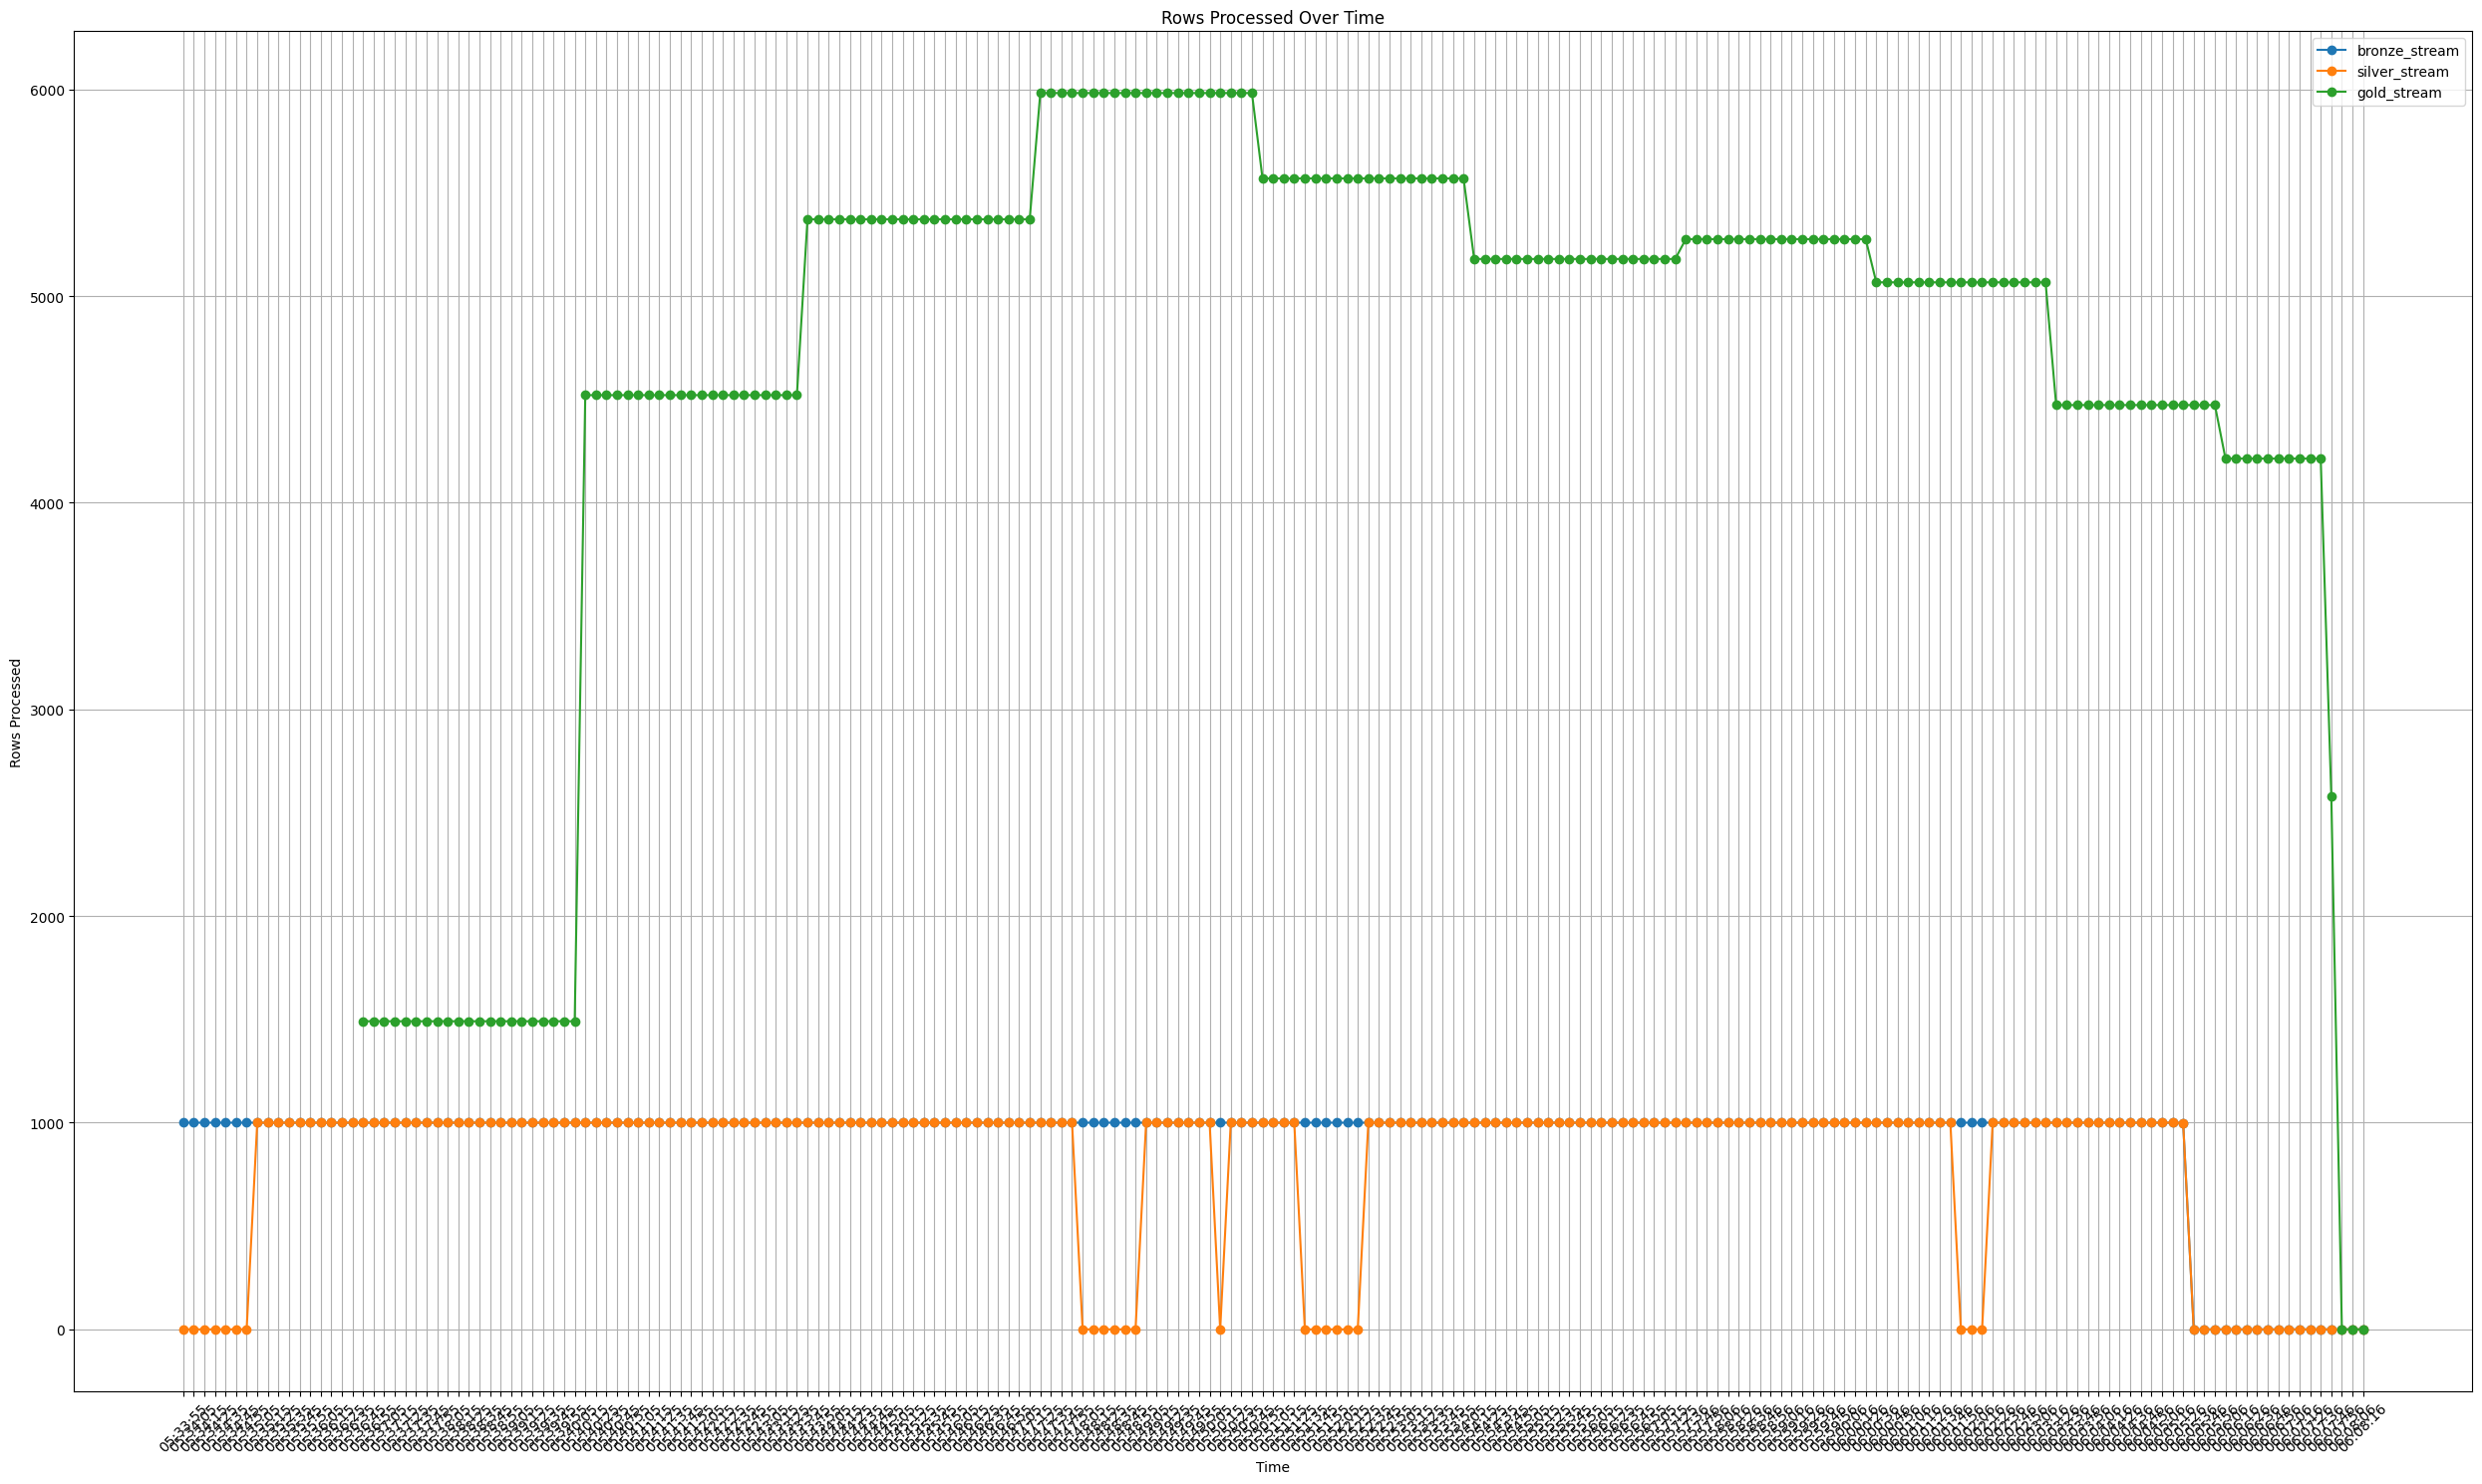

In [0]:
# Convert to Pandas DataFrame
df_monitor = pd.DataFrame(monitoring_data)

# Plot: Rows processed over time
plt.figure(figsize=(25, 15))
for stream in df_monitor["stream"].unique():
    subset = df_monitor[df_monitor["stream"] == stream]
    plt.plot(subset["timestamp"], subset["rows"], marker="o", label=stream)

plt.title("Rows Processed Over Time")
plt.xlabel("Time")
plt.ylabel("Rows Processed")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


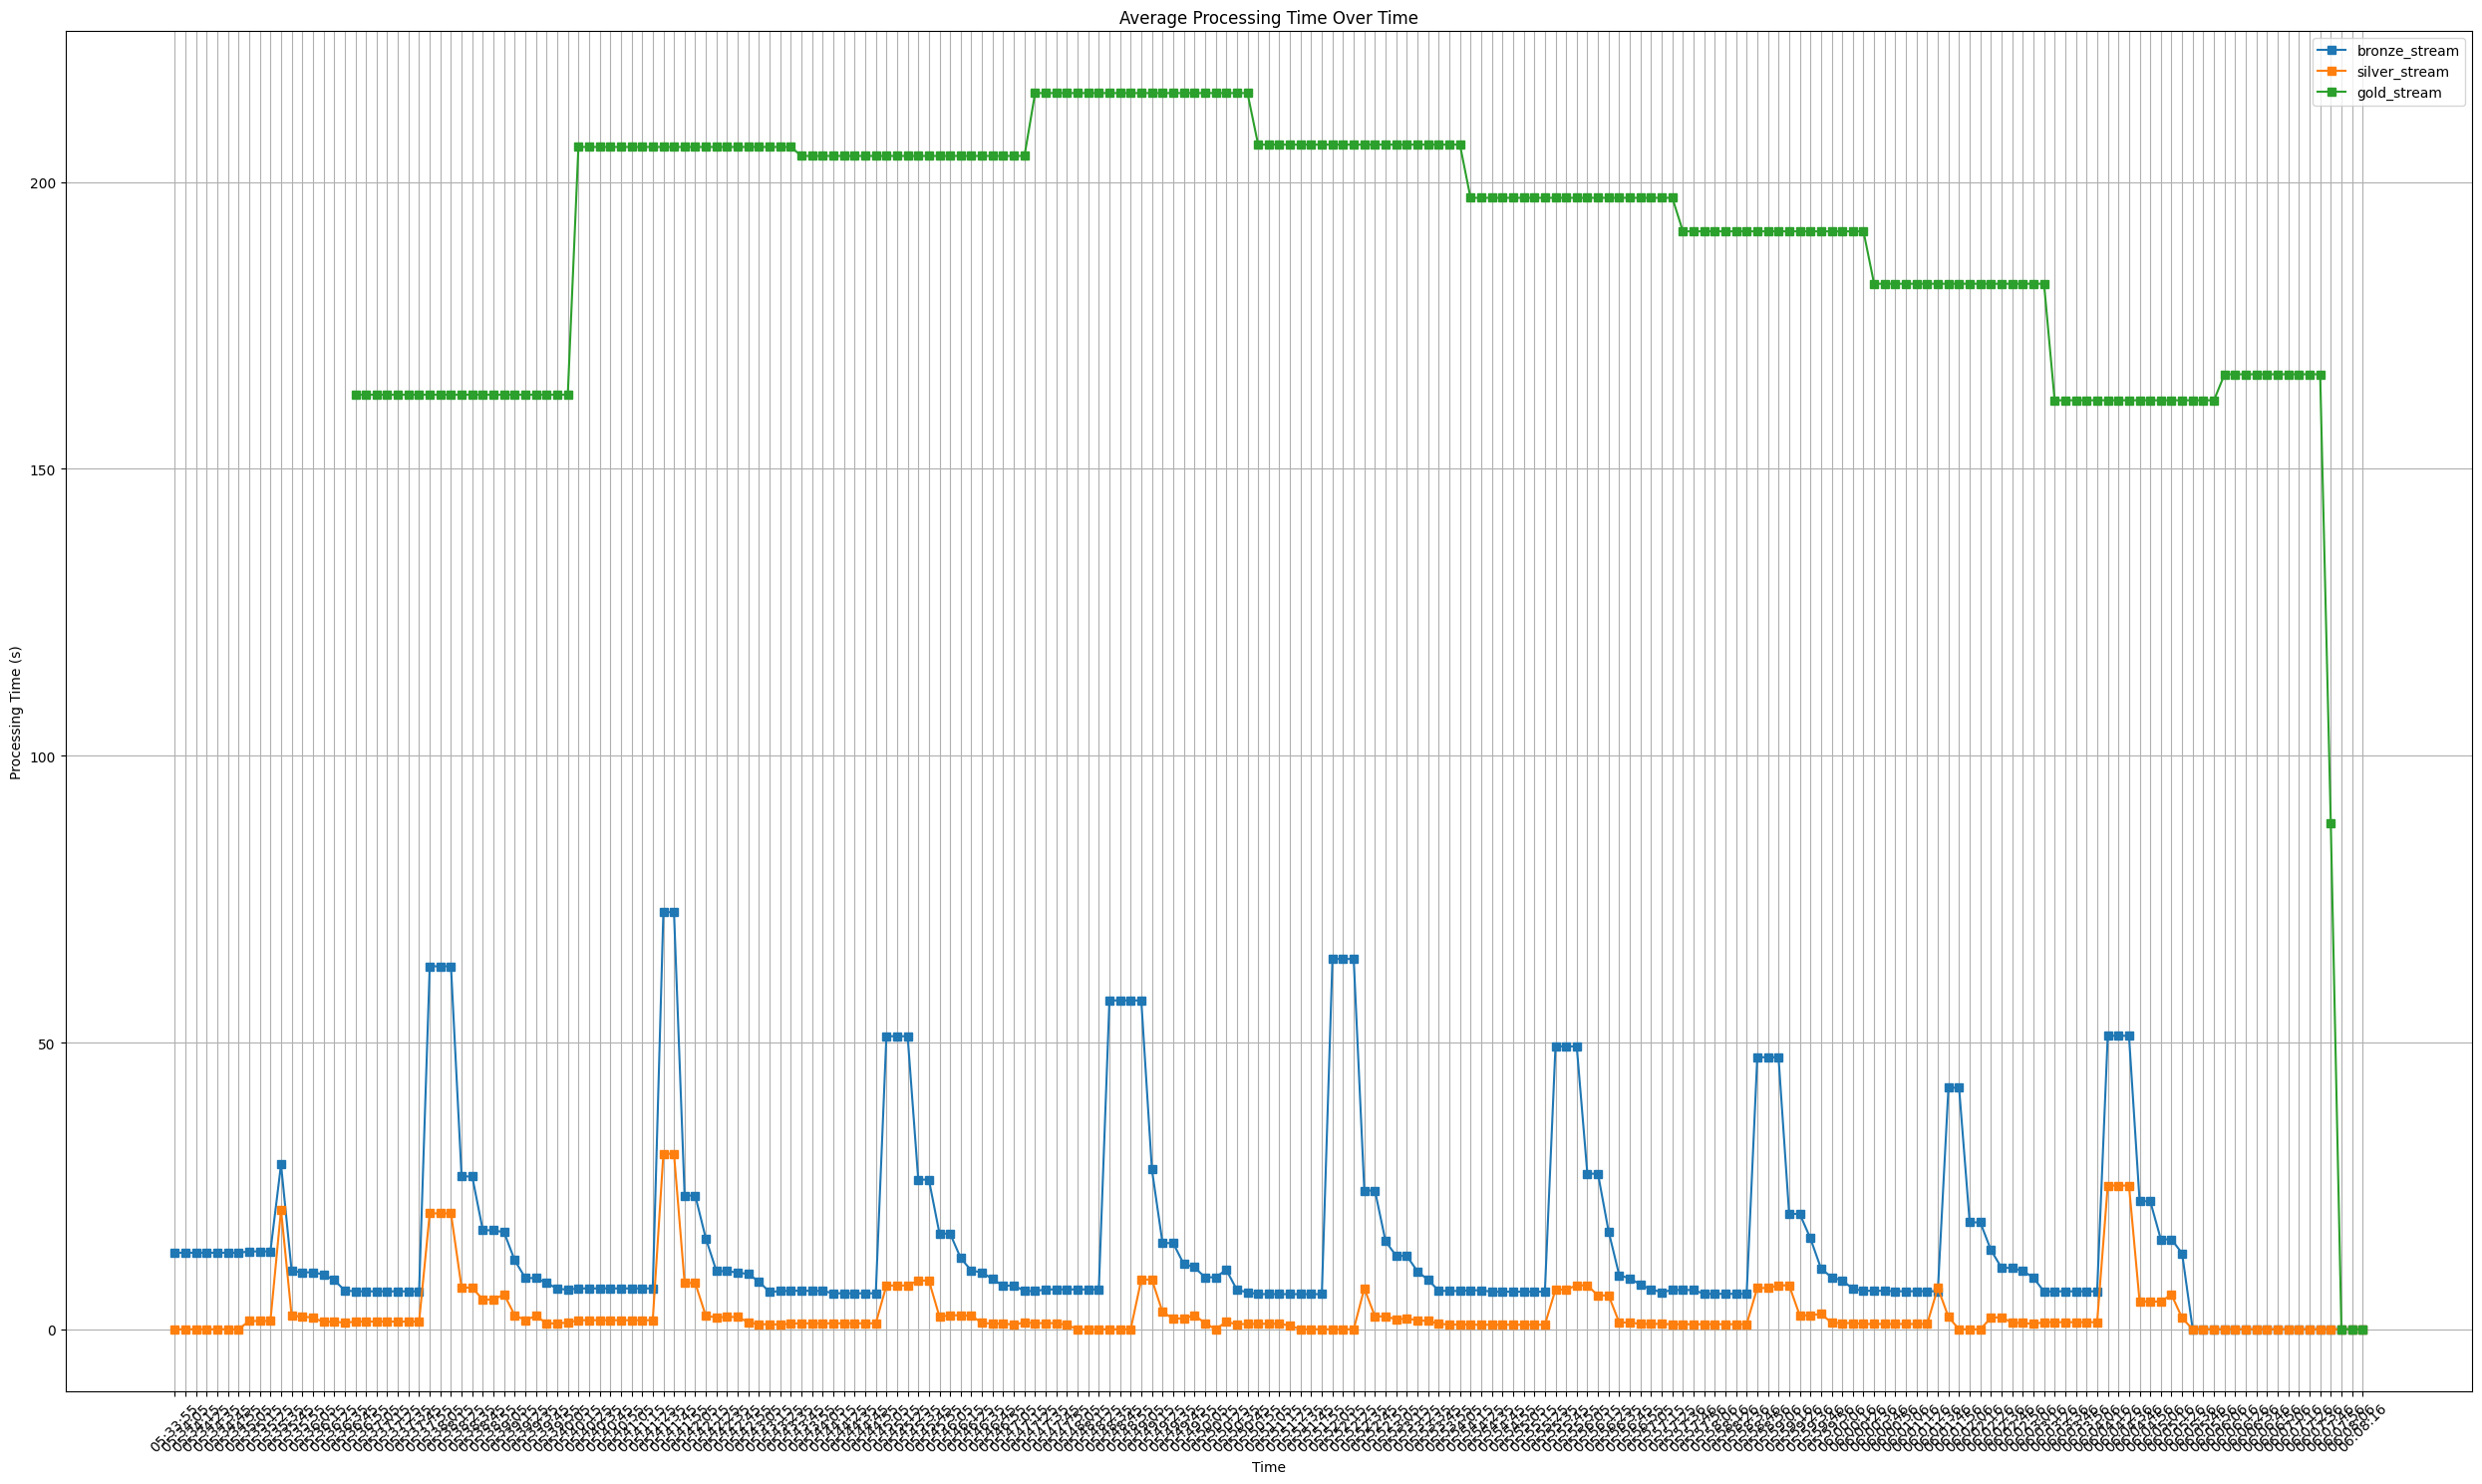

In [0]:
# Plot: Processing time over time
plt.figure(figsize=(25, 15))
for stream in df_monitor["stream"].unique():
    subset = df_monitor[df_monitor["stream"] == stream]
    plt.plot(subset["timestamp"], subset["time"], marker="s", label=stream)

plt.title("Average Processing Time Over Time")
plt.xlabel("Time")
plt.ylabel("Processing Time (s)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 7.0 Bronze Data Exploratory Data Analysis (5 points)
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
# ENTER YOUR CODE HERE
# Load Bronze data (batch read)
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

In [0]:
tweet_count = bronze_df.count()
print(f"Total number of tweets in Bronze Table: {tweet_count}")

Total number of tweets in Bronze Table: 100000


In [0]:
from pyspark.sql.functions import col, isnan

null_summary = bronze_df.select([
    col(c).isNull().cast("int").alias(c) for c in bronze_df.columns
]).groupBy().sum().toPandas().T

null_summary.columns = ["Null Count"]
print(null_summary)

                      Null Count
sum(date)                      0
sum(user)                      0
sum(text)                      0
sum(sentiment)                 0
sum(source_file)               0
sum(processing_time)           0


In [0]:
from pyspark.sql.functions import desc

user_tweet_counts = bronze_df.groupBy("user").count().orderBy(desc("count"))
user_tweet_counts.show(10)

+--------------+-----+
|          user|count|
+--------------+-----+
|      tweetpet|  132|
|     iHomeTech|   69|
|    nuttychris|   58|
|Hollywood_Trey|   56|
|    sebby_peek|   39|
|    SarahSaner|   36|
|       Dogbook|   35|
|      tsarnick|   35|
|   whitsundays|   32|
|  MyAppleStuff|   31|
+--------------+-----+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import col

with_mentions = bronze_df.filter(col("text").contains("@")).count()
without_mentions = bronze_df.filter(~col("text").contains("@")).count()

print(f"Tweets with @ mentions: {with_mentions}")
print(f"Tweets without @ mentions: {without_mentions}")

Tweets with @ mentions: 47323
Tweets without @ mentions: 52677


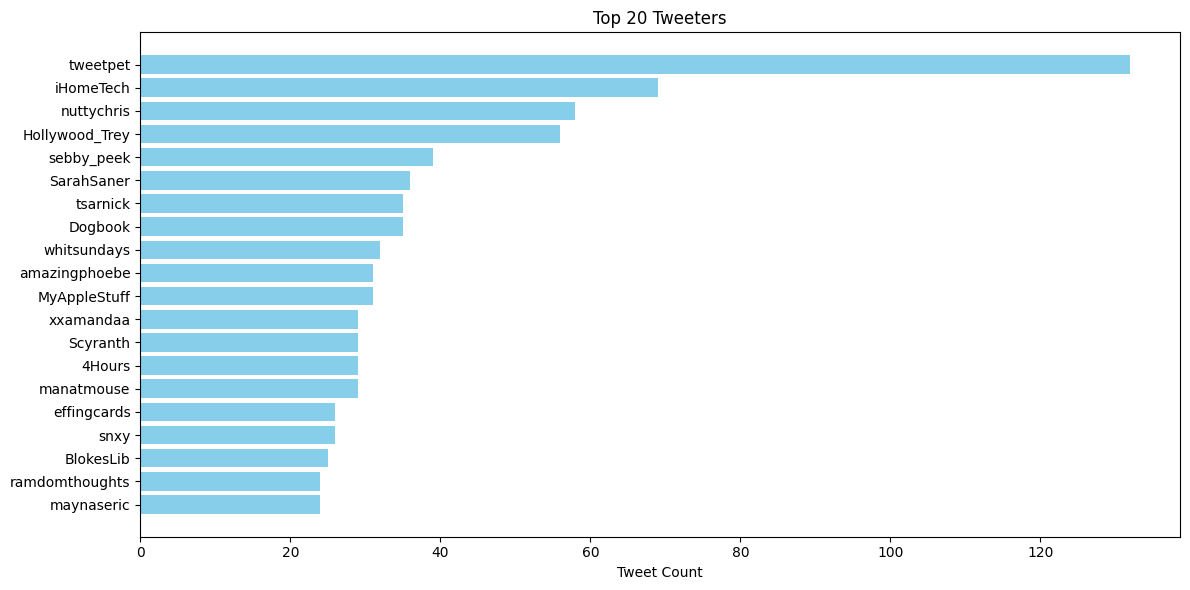

In [0]:
# Convert top 20 tweeters to Pandas for plotting
top20_users = user_tweet_counts.limit(20).toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(top20_users["user"], top20_users["count"], color='skyblue')
plt.xlabel("Tweet Count")
plt.title("Top 20 Tweeters")
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

## 8.0 Capture the accuracy metrics from the gold table in MLflow  (4 points)
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the model name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
# === Imports ===
import mlflow
from mlflow import MlflowClient
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from delta.tables import DeltaTable
from pyspark.sql import SparkSession

# === Step 1: Load Gold Delta Table ===
gold_df = spark.read.format("delta").load(GOLD_DELTA).toPandas()

# === Step 2: Drop missing predictions or labels ===
gold_df = gold_df.dropna(subset=["sentiment_id", "predicted_sentiment_id"])

# === Step 3: Convert to integers ===
y_true = gold_df["sentiment_id"].astype(int)
y_pred = gold_df["predicted_sentiment_id"].astype(int)

# === Step 4: Compute metrics ===
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)

# === Step 5: Plot confusion matrix ===
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# Save the plot
conf_matrix_path = "/tmp/confusion_matrix.png"
plt.savefig(conf_matrix_path)
plt.close()

# === Step 6: Get model version from MLflow Registry ===
client = MlflowClient()
model_version = client.get_latest_versions(MODEL_NAME, stages=["Production"])[0].version

# === Step 7: Get Delta Table version of Silver input ===
silver_version = DeltaTable.forPath(spark, SILVER_DELTA).history().select("version").first()["version"]

# === Step 8: Start MLflow run and log everything ===
with mlflow.start_run(run_name="Gold Evaluation Metrics"):
    # Log metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Log parameters
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("model_version", model_version)
    mlflow.log_param("silver_table_version", silver_version)

    # Log confusion matrix plot
    mlflow.log_artifact(conf_matrix_path)

print("✅ Evaluation complete and all metrics/artifacts logged to MLflow.")


/root/.ipykernel/1496/command-6786773841211814-504775626:42: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  model_version = client.get_latest_versions(MODEL_NAME, stages=["Production"])[0].version


✅ Evaluation complete and all metrics/artifacts logged to MLflow.


## 9.0 Application Data Processing and Visualization (6 points)
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
# Load Gold Delta table as batch
gold_df = spark.read.format("delta").load(GOLD_DELTA)

In [0]:
from pyspark.sql.functions import upper, trim

In [0]:
gold_df.select("Predicted_sentiment").distinct().show(truncate=False)


+-------------------+
|Predicted_sentiment|
+-------------------+
|POS                |
|NEG                |
|NEU                |
|UNKNOWN            |
+-------------------+



In [0]:
mention_summary = (
    gold_df.groupBy("mention")
    .agg(
        count("*").alias("total"),
        count(when(upper(trim(col("Predicted_sentiment"))) == "POS", True)).alias("positive"),
        count(when(upper(trim(col("Predicted_sentiment"))) == "NEU", True)).alias("neutral"),
        count(when(upper(trim(col("Predicted_sentiment"))) == "NEG", True)).alias("negative")
    )
    .orderBy(col("total").desc())
)


In [0]:
total_mentions = mention_summary.count()
print(f"Total unique mentions in the gold data: {total_mentions}")

Total unique mentions in the gold data: 35080


In [0]:
mention_pdf = mention_summary.toPandas()

In [0]:
mention_pdf[['mention', 'positive', 'negative']].sort_values(by='positive', ascending=False).head(10)

,mention,positive,negative
0,@,262,145
1,@mileycyrus,224,44
2,@ddlovato,181,30
3,@tommcfly,175,33
4,@JonathanRKnight,88,11
5,@nick_carter,72,20
9,@selenagomez,71,2
10,@MariahCarey,56,11
8,@dougiemcfly,53,16
11,@DonnieWahlberg,53,15


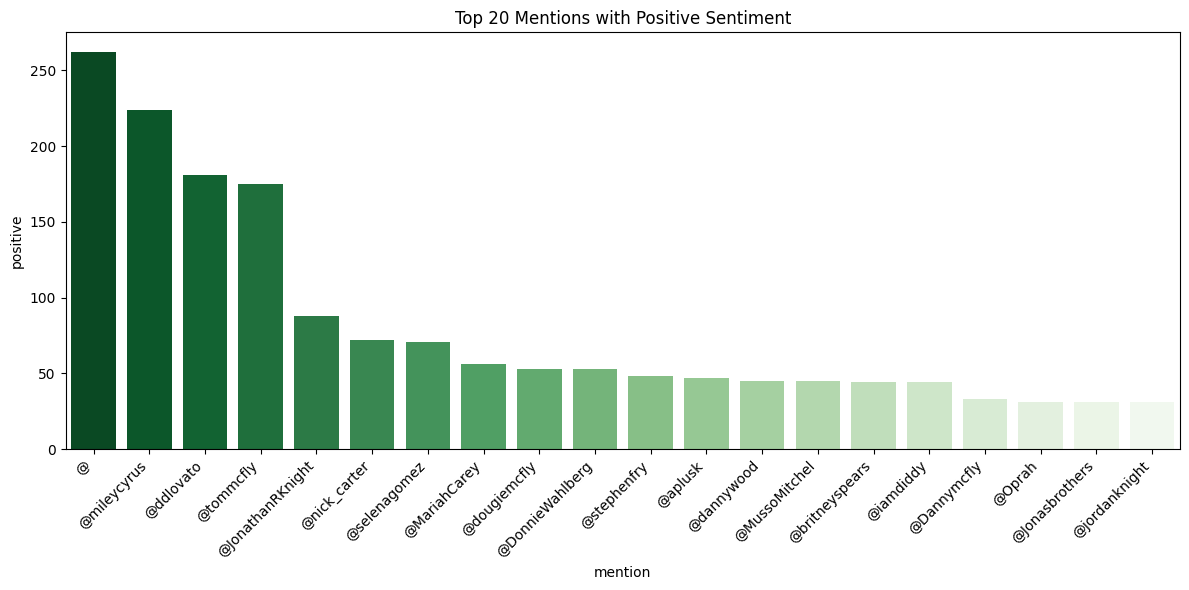

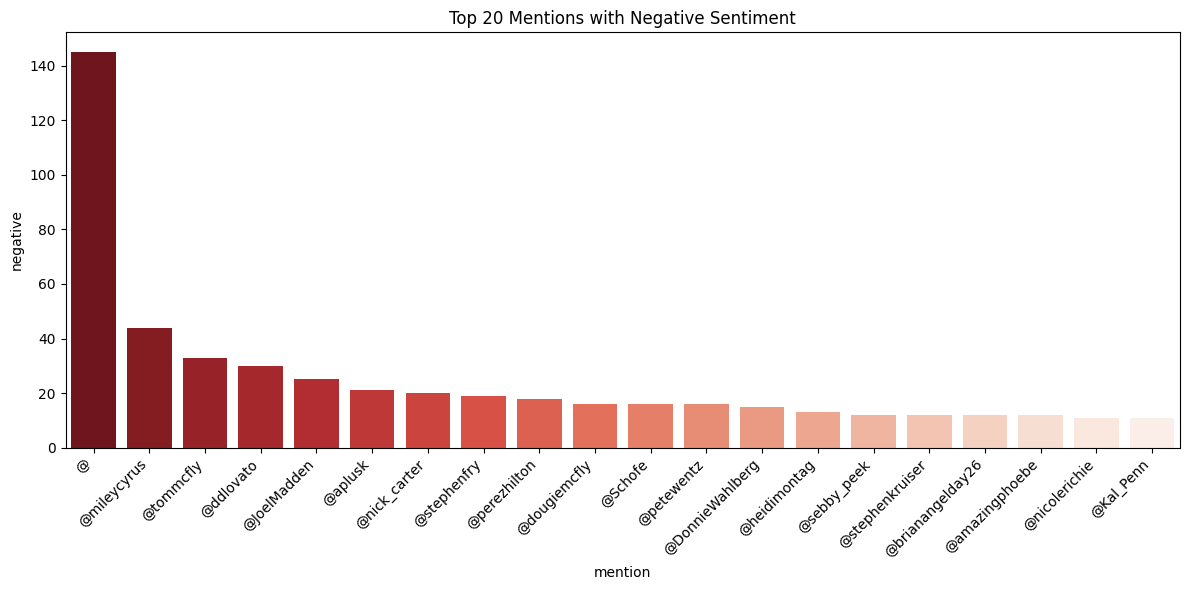

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 20 positive
top_pos = mention_pdf.sort_values(by="positive", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_pos, x="mention", y="positive", palette="Greens_r")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Mentions with Positive Sentiment")
plt.tight_layout()
plt.show()

# Top 20 negative
top_neg = mention_pdf.sort_values(by="negative", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_neg, x="mention", y="negative", palette="Reds_r")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Mentions with Negative Sentiment")
plt.tight_layout()
plt.show()


## 10.0 Clean up and completion of your pipeline (3 points)
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook. Note: In the includes there is a variable START_TIME that captures the starting time of the notebook.

In [0]:
# ENTER YOUR CODE HERE
# List all currently active streams
print("🔍 Active Streams:")
for query in spark.streams.active:
    print(f"- {query.name} | Is Active: {query.isActive} | Status: {query.status['message']}")

🔍 Active Streams:
- gold_stream | Is Active: True | Status: Waiting for data to arrive
- bronze_stream | Is Active: True | Status: Waiting for data to arrive
- silver_stream | Is Active: True | Status: Waiting for data to arrive


In [0]:
print("🛑 Stopping all active streams...")
for query in spark.streams.active:
    print(f"Stopping stream: {query.name}")
    query.stop()

🛑 Stopping all active streams...
Stopping stream: gold_stream
Stopping stream: bronze_stream
Stopping stream: silver_stream


In [0]:
from datetime import datetime

# Convert START_TIME from float to datetime object
start_dt = datetime.fromtimestamp(START_TIME)
end_dt = datetime.now()

elapsed = end_dt - start_dt
print(f"⏱️ Notebook Elapsed Time: {elapsed}")

⏱️ Notebook Elapsed Time: 1:44:14.353556


## 11.0 How Optimized is your Spark Application (Grad Students Only) (5 points)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### ENTER YOUR MARKDOWN HERE

## 11.0 Spark Application Performance Analysis 

### 1. **Spill (Memory Spill to Disk)**  
> Spark spills data when memory is insufficient for shuffle operations.

- Observed that Stage 1034, which likely corresponds to the Bronze stream or a lightweight processing stage, completed without any memory or disk spill. 
- Task deserialization was minimal (2ms), and no shuffle or serialization delays were present. 
- This indicates that the Spark executor had sufficient memory to process the task entirely  in-memory

*See screenshot below*  
https://drive.google.com/file/d/1CtvHSfpE2RjQjop0oVfwdNSZS151dNfy/view?usp=drive_link
https://drive.google.com/file/d/1QY3o5F1sRNv-DP7mV8T5_doCg-pnsiFc/view?usp=drive_link

---

### 2. **Skew (Data Partition Skew)**  
> Skew occurs when some partitions are much larger than others.

- Analyzed Stage 1026, which included a shuffle and grouped data by mention.
- The Event Timeline shows four parallel tasks executing with nearly identical duration.
- Task metrics confirm uniform distribution of records and compute load.
- No skew observed.

*See screenshot below*  
https://drive.google.com/file/d/1pmcVaBYpmUANNTr8atlXRonKgRhQ5Biu/view?usp=drive_link
https://drive.google.com/file/d/1EJc0F2OE-o7eB0IPPOh_16BOIGOaLpyd/view?usp=drive_link

---

### 3. **Shuffle (Wide Transformations)**  
> Shuffle occurs during wide transformations like `groupBy`, `join`.

- Stage 1026 triggered a shuffle due to `groupBy(mention)` during aggregation.
- Shuffle write sizes per task were moderate (up to ~250 KiB), with no signs of slowdown.
- All tasks completed in roughly the same time (0.2s), indicating good parallelism and no imbalance.

*See screenshot below* <br>
https://drive.google.com/file/d/1pmcVaBYpmUANNTr8atlXRonKgRhQ5Biu/view?usp=drive_link <br>
https://drive.google.com/file/d/1EJc0F2OE-o7eB0IPPOh_16BOIGOaLpyd/view?usp=drive_link

---

### 4. **Storage (Delta Format & Small Files)**  
> Efficient storage improves performance, especially with Delta Lake.

- Used Delta format across Bronze, Silver, and Gold layers.
- Streaming writes succeeded with moderate file sizes and no job failures.
- Not observed performance issues due to small files.
- Job 451 shows 3 stages completed with successful Delta writes and consistent output sizes.

*See screenshot below* <br>
https://drive.google.com/file/d/1PBKtfk4ydLwEqQfbaoIzglv1cBJY6q4E/view?usp=drive_link

---

### 5. **Serialization (UDF + Model Overhead)**  
> Serialization overhead comes from UDFs or large Python objects.

- Used a Spark UDF (`@udf(...)`) that wraps an MLflow sentiment model.
- The model was loaded once per executor, avoiding per-row overhead.
- Stage 921 shows 4 tasks completing with consistent durations and 0 ms `Result Serialization Time`.
- No task failures or lag observed, confirming efficient serialization.

*See screenshot below* <br>
https://drive.google.com/file/d/18tjT-hKuuyqzg6MwWa3SMqhUFZ1U6E-B/view?usp=drive_link <br>
https://drive.google.com/file/d/153iWmx6CFyhWM7YVRb92sol6OdACar8p/view?usp=drive_link


